# Cluster extraction and annotation strategies on tabular datasets with diverse feature types

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import umap.umap_ as umap
%config InlineBackend.figure_format = 'svg'

## Importing pre-processed data

In [2]:
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
data=pd.read_csv('Preprocessed_DM_xx.csv')


In [3]:
np.random.seed(42)
data=data.sample(frac=1) #Shuffle the data set

## Feature engineering

- Creating new feature called hypertension
- Filtering unnecessary details 

In [4]:
np.random.seed(42)
HTN_indexes=data.loc[(data['Currently.taking.a.prescribed.medicine.to.lower.BP'] != 0) | (data['First.SYSTOLIC.reading'] >= 140) | (data['First.DIASTOLIC.reading'] >= 90) ].index.values
HTN_cols=np.zeros(data.shape[0])
HTN_cols[[HTN_indexes]]=1
data['HTN']=HTN_cols
data=data.drop(["First.SYSTOLIC.reading","First.DIASTOLIC.reading","Currently.taking.a.prescribed.medicine.to.lower.BP"], axis=1)
data=data.reset_index(drop=True)
data.columns
data=data.drop(["Hb_adjust_alt_smok","Second.SYSTOLIC.reading","Second.DIASTOLIC.reading","Third.SYSTOLIC.reading","Third.DIASTOLIC.reading","Hb_status","Glucose.level",'SBP_status'], axis=1)
data=data.loc[data['BMI'] != 99.99]
data=data.loc[data['Hemoglobin.level..g.dl...1.decimal.'] != 99.99]
data=data.loc[data['Currently.has.asthma'] != .5]
data=data.loc[data['Currently.has.thyroid.disorder'] != .5]
data=data.loc[data['Currently.has.heart.disease'] != .5]
data=data.loc[data['Currently.has.cancer'] != .5]
data=data.loc[data['DM_history'] == 1]
data=data.loc[data['Type.of.caste.or.tribe.of.the.household.head'] != 0]
data=data.loc[data['Time.to.get.to.water.source..minutes.'] != -1]
data=data.drop(["Unnamed: 0","DM_status","DM_history"], axis=1)

In [5]:
np.random.seed(42)
i=[x for x in range(10125)]

data.set_index(pd.Series(i), inplace=True) # Reset the index

## Spliting features 

Creating 2 new dataframes: "data_disease" with features related to disease and "data_others" with rest of the features


In [6]:
data_disease= data[['Currently.has.asthma',
       'Currently.has.thyroid.disorder', 'Currently.has.heart.disease',
       'Currently.has.cancer', 'Suffers.from.TB','HTN']]

In [7]:
data_others= data[['Drinks.alcohol', 'Smoking_stat','Has.refrigerator',
       'Has.bicycle', 'Has.motorcycle.scooter', 'Has.car.truck', 'Owns.livestock..herds.or.farm.animals','Frequency.takes.milk.or.curd',
       'Frequency.eats.pulses.or.beans',
       'Frequency.eats.dark.green.leafy.vegetable', 'Frequency.eats.fruits',
       'Frequency.eats.eggs', 'Frequency.eats.fish',
       'Frequency.eats.chicken.or.meat', 'Frequency.eats.fried.food',
       'Frequency.takes.aerated.drinks','Frequency.household.members.smoke.inside.the.house','Wealth.index',
       'Highest.educational.level', 'Current.age','BMI','Hemoglobin.level..g.dl...1.decimal.','Time.to.get.to.water.source..minutes.', 'Household.head.s.religion', 'Sex', 'Type.of.place.of.residence', 'Household.structure',
       'Type.of.caste.or.tribe.of.the.household.head','Type.of.cooking.fuel','Source.of.drinking.water']]

## Function for dimension reduction using UMAP

In [8]:
def feature_clustering(UMAP_neb,min_dist_UMAP, metric, data, visual):
    import umap.umap_ as umap
    np.random.seed(42)
    data_embedded = umap.UMAP(n_neighbors=UMAP_neb, min_dist=min_dist_UMAP, n_components=2, metric=metric, random_state=42).fit_transform(data)
    data_embedded[:,0]=(data_embedded[:,0]- np.mean(data_embedded[:,0]))/np.std(data_embedded[:,0])
    data_embedded[:,1]=(data_embedded[:,1]- np.mean(data_embedded[:,1]))/np.std(data_embedded[:,1])
    result = pd.DataFrame(data = data_embedded , 
        columns = ['UMAP_0', 'UMAP_1'])
    if visual==1:
        sns.lmplot( x="UMAP_0", y="UMAP_1",data=result,fit_reg=False,legend=False,scatter_kws={"s": 3},palette=customPalette_set1) # specify the point size
        #plt.savefig('clusters_umap_all.png', dpi=700, bbox_inches='tight')
        plt.show()
    else:
        pass
    return result

## Dividing features
- ord_list=ordinal features
- cont_list=continueous features
- nom_list=nominal features

In [9]:
ord_list=['Drinks.alcohol', 'Smoking_stat','Has.refrigerator',
       'Has.bicycle', 'Has.motorcycle.scooter', 'Has.car.truck', 'Owns.livestock..herds.or.farm.animals','Frequency.takes.milk.or.curd',
       'Frequency.eats.pulses.or.beans',
       'Frequency.eats.dark.green.leafy.vegetable', 'Frequency.eats.fruits',
       'Frequency.eats.eggs', 'Frequency.eats.fish',
       'Frequency.eats.chicken.or.meat', 'Frequency.eats.fried.food',
       'Frequency.takes.aerated.drinks','Frequency.household.members.smoke.inside.the.house','Wealth.index',
       'Highest.educational.level' ]
cont_list=['Current.age','BMI','Hemoglobin.level..g.dl...1.decimal.','Time.to.get.to.water.source..minutes.']
nom_list=['Household.head.s.religion', 'Sex', 'Type.of.place.of.residence', 'Household.structure',
       'Type.of.caste.or.tribe.of.the.household.head','Type.of.cooking.fuel','Source.of.drinking.water']

## Function for Feature-type Distributed Clustering
### Function parameters:
- data=dataframe on which feature distributed clustering should be performed
- cont_list=list of continueous features
- nom_list=list of nominal features
- ord_list=list of ordinal features
- cont_metric=distance metric for continueous data
- ord_metric=distance metric for ordinal data
- nom_metric=distance metric for nominal data
- drop_nominal=1(to drop nominal data) or 0(don't drop nominal data)
- visual=1(to plot the data) or 0(don't plot the data)

In [10]:
def FDC(data,cont_list,nom_list,ord_list,cont_metric, ord_metric, nom_metric, drop_nominal, visual):
    np.random.seed(42)
    colors_set1 = ["lightcoral", "lightseagreen", "mediumorchid", "orange", "burlywood", "cornflowerblue", "plum", "yellowgreen"]
    customPalette_set1 = sns.set_palette(sns.color_palette(colors_set1))
    cont_df=data[cont_list]
    nom_df=data[nom_list]
    ord_df=data[ord_list]
    cont_emb=feature_clustering(30,0.1, cont_metric, cont_df, 0) #Reducing continueous features into 2dim
    ord_emb=feature_clustering(30,0.1, ord_metric, ord_df, 0) #Reducing ordinal features into 2dim
    nom_emb=feature_clustering(30,0.1, nom_metric, nom_df, 0) #Reducing nominal features into 2dim
    if drop_nominal==1:
        result_concat=pd.concat([ord_emb, cont_emb, nom_emb.drop(['UMAP_1'],axis=1)],axis=1) #concatinating all reduced dimensions to get 5D embedding(1D from nominal)
    else:
        result_concat=pd.concat([ord_emb, cont_emb, nom_emb],axis=1)
    data_embedded = umap.UMAP(n_neighbors=30, min_dist=0.001, n_components=2, metric='euclidean', random_state=42).fit_transform(result_concat) #reducing 5D embedding to 2D using UMAP
    result_reduced = pd.DataFrame(data = data_embedded , 
        columns = ['UMAP_0', 'UMAP_1'])
    
    if visual==1:
        sns.lmplot( x="UMAP_0", y="UMAP_1",data=result_reduced,fit_reg=False,legend=False,scatter_kws={"s": 3},palette=customPalette_set1) # specify the point size
        plt.show()
        #plt.savefig('clusters_umap_all.png', dpi=700, bbox_inches='tight')
    else:
        pass
    return result_concat, result_reduced #returns both 5D and 2D embedding

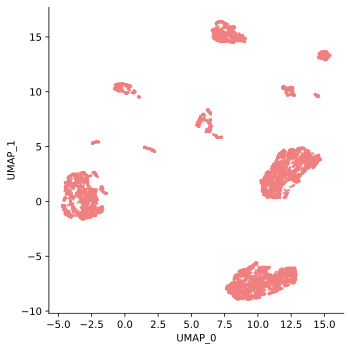

In [11]:
# applying Feature Distributed Clustering(FDC) on entire 10125 data with all features except disease features
entire_data_FDC_emb_five,entire_data_FDC_emb_two=FDC(data_others,cont_list,nom_list,ord_list,'euclidean','canberra','hamming',1,1)

## Agglomerative clustering on FDC embedding

In [12]:
def aglo_clustering(no_of_clusters, affinity, linkage, two_d_embedding,visual,pal):
    np.random.seed(42)
    from sklearn.cluster import AgglomerativeClustering
    colors_set1 = ['lightcoral','cornflowerblue','orange','mediumorchid', "burlywood", "cornflowerblue", "plum", "yellowgreen"]
    customPalette_set1 = sns.set_palette(sns.color_palette(colors_set1))
    ag_cluster = AgglomerativeClustering(n_clusters=no_of_clusters,affinity=affinity,linkage=linkage)
    clusters=ag_cluster.fit_predict(two_d_embedding)
    (values,counts) = np.unique(clusters,return_counts=True)
    two_d_embedding['Cluster'] = clusters
    
    if visual==1:
        sns.lmplot( x="UMAP_0", y="UMAP_1",
        data=two_d_embedding,
        fit_reg=False, 
        legend=True,
        hue='Cluster', # color by cluster
        scatter_kws={"s": 3},palette=pal) # specify the point size
        plt.savefig('agglo_ref_2dim', dpi=700, bbox_inches='tight')
        plt.show()
    else:
        pass
    return two_d_embedding.Cluster.to_list(),counts


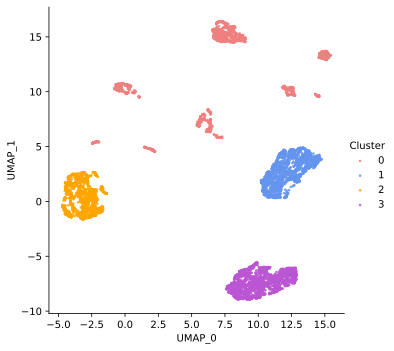

In [13]:
#setting color palette for visualization of clusters
colors_set1 = ['lightcoral','cornflowerblue','orange','mediumorchid', 'lightseagreen','olive', 'chocolate','steelblue']
customPalette_set1 = sns.set_palette(sns.color_palette(colors_set1))


#Applying clustering algorithm on FDC embedding from entire data
entire_data_cluster_list,entire_data_cluster_counts=aglo_clustering(4, "euclidean", "ward",entire_data_FDC_emb_two,1,customPalette_set1)


In [14]:
#Getting noise indices
non_noise_indices= np.where(np.array(entire_data_cluster_list)!=-1)

#Removing noise/outlires from FDC embedding and from entire data
entire_data_FDC_emb_five= entire_data_FDC_emb_five.iloc[non_noise_indices]
entire_data_FDC_emb_two= entire_data_FDC_emb_two.iloc[non_noise_indices]
entire_data_cluster_list= np.array(entire_data_cluster_list)[non_noise_indices]
data_others= data_others.iloc[non_noise_indices]

#Creating new cloumn for storing cluster labels 
data_others['cluster_labels']= entire_data_cluster_list

#getting binary representation for cluster labels
data_others= pd.get_dummies(data=data_others, columns=['cluster_labels'])

In [15]:
#Getting column names of encoded cluster labels
cluster_column_names=data_others.columns[-len(np.unique(entire_data_cluster_list)):].to_list()

## Dividing data set for experiments

In [16]:
#75%  of entire data for training
np.random.seed(42)
data=data_others.sample(frac=0.75) # Training data

In [17]:
#Another 25% of entire data for validation
np.random.seed(42)
data_val=data_others.drop(data.index) # Validation data

## Dividing training data into 3 folds

In [18]:
#Dividing training data into three folds

np.random.seed(42)
df_1=data.sample(frac=0.33) #fold 1

df=data.drop(df_1.index)
df_2=df.sample(frac=0.51) #fold 2

df_3=df.drop(df_2.index) #fold 3

In [19]:
np.random.seed(42)
#Possible combinations of concating 2 folds for training and using remaining fold for testing
training_folds=[pd.concat([df_1,df_2],axis=0), pd.concat([df_2,df_3],axis=0), pd.concat([df_3,df_1],axis=0)]
testing_folds=[df_3,df_1,df_2]

## Function for neural network
### Function parameters:
- n_features= dimension of input data
- hidden_dim1= dimension of first hidden layer
- hidden_dim2= dimension of second hidden layer
- out_emb_size= dimension of output data
- act1= first hidden layer activation function
- act2= second hidden layer activation function

In [20]:
def neural_network(n_features,hidden_dim1,hidden_dim2,out_emb_size,act1,act2,loss):
    np.random.seed(42)
    tf.random.set_seed(42)
    model=keras.Sequential([
         keras.layers.Dense(hidden_dim1,input_dim=n_features,activation=act1),
         keras.layers.Dense(hidden_dim1,activation=act2),
         keras.layers.Dense(out_emb_size)])
    model.compile(optimizer="adam" ,
              loss=loss, 
              metrics=['mse'])
    return model    

## Function for Cluster Incidence Matrix (CIM)
- creating a matrix to evaluate the performance based on predicted cluster labels

In [21]:
def cluster_incidence_matrix_mod(cluster_list_new):
    np.random.seed(42)
    
    matrix=np.zeros((len(cluster_list_new),len(cluster_list_new)))
    for i in range(len(cluster_list_new)):
        for j in range(len(cluster_list_new)):
                if cluster_list_new[i]==cluster_list_new[j]:
                    matrix[i,j]=1 
                else:
                    pass
    
    return matrix 

In [22]:
#Function for decoding the encoded cluster labels
def label_decoder(label_dataframe):
    label_array=np.array(label_dataframe)
    decoded_labels=[]
    for i in label_array:
        max_val=np.argmax(i)
        decoded_labels.append(max_val)
    return decoded_labels

In [23]:
colnames=[]
for i in range(len(entire_data_FDC_emb_five.columns)):
    colnames.append('c'+str(i+1))

Epoch 1/30
638/638 [==============================] - 1s 1ms/step - loss: 0.7376 - mse: 0.7376
Epoch 2/30
638/638 [==============================] - 1s 1ms/step - loss: 0.4387 - mse: 0.4387
Epoch 3/30
638/638 [==============================] - 1s 986us/step - loss: 0.3622 - mse: 0.3622
Epoch 4/30
638/638 [==============================] - 1s 999us/step - loss: 0.3286 - mse: 0.3286
Epoch 5/30
638/638 [==============================] - 1s 1ms/step - loss: 0.3076 - mse: 0.3076
Epoch 6/30
638/638 [==============================] - 1s 1ms/step - loss: 0.2948 - mse: 0.2948
Epoch 7/30
638/638 [==============================] - 1s 1ms/step - loss: 0.2838 - mse: 0.2838
Epoch 8/30
638/638 [==============================] - 1s 1ms/step - loss: 0.2769 - mse: 0.2769
Epoch 9/30
638/638 [==============================] - 1s 1ms/step - loss: 0.2704 - mse: 0.2704
Epoch 10/30
638/638 [==============================] - 1s 1ms/step - loss: 0.2645 - mse: 0.2645
Epoch 11/30
638/638 [========================

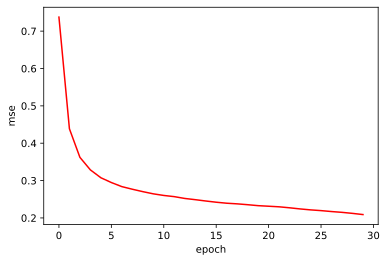

Epoch 1/30
638/638 [==============================] - 1s 1ms/step - loss: 0.1622 - mse: 0.1622
Epoch 2/30
638/638 [==============================] - 1s 1ms/step - loss: 0.1003 - mse: 0.1003
Epoch 3/30
638/638 [==============================] - 1s 1ms/step - loss: 0.0621 - mse: 0.0621
Epoch 4/30
638/638 [==============================] - 1s 1ms/step - loss: 0.0399 - mse: 0.0399
Epoch 5/30
638/638 [==============================] - 1s 1ms/step - loss: 0.0335 - mse: 0.0335
Epoch 6/30
638/638 [==============================] - 1s 1ms/step - loss: 0.0310 - mse: 0.0310
Epoch 7/30
638/638 [==============================] - 1s 1ms/step - loss: 0.0293 - mse: 0.0293
Epoch 8/30
638/638 [==============================] - 1s 1ms/step - loss: 0.0281 - mse: 0.0281
Epoch 9/30
638/638 [==============================] - 1s 1ms/step - loss: 0.0274 - mse: 0.0274
Epoch 10/30
638/638 [==============================] - 1s 1ms/step - loss: 0.0265 - mse: 0.0265
Epoch 11/30
638/638 [============================

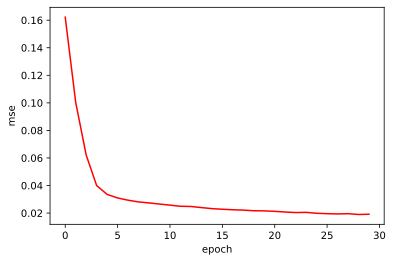

78/78 [==============================] - 0s 811us/step
Vizualization for FDC for training fold (shown in dark hue) 1and predicted clusters from neural network on testing fold (shown in corresponding light hues) 1


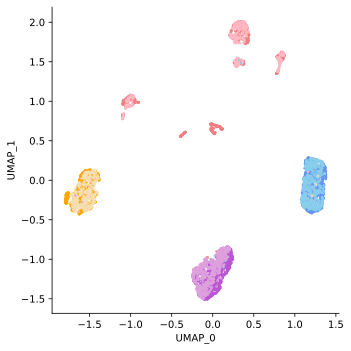

Average percentage of patients belongs to the same cluster is: 91.7757452564867%


Epoch 1/30
636/636 [==============================] - 1s 938us/step - loss: 0.7368 - mse: 0.7368
Epoch 2/30
636/636 [==============================] - 1s 1ms/step - loss: 0.4379 - mse: 0.4379
Epoch 3/30
636/636 [==============================] - 1s 988us/step - loss: 0.3580 - mse: 0.3580
Epoch 4/30
636/636 [==============================] - 1s 1ms/step - loss: 0.3246 - mse: 0.3246
Epoch 5/30
636/636 [==============================] - 1s 1ms/step - loss: 0.3044 - mse: 0.3044
Epoch 6/30
636/636 [==============================] - 1s 985us/step - loss: 0.2908 - mse: 0.2908
Epoch 7/30
636/636 [==============================] - 1s 1ms/step - loss: 0.2831 - mse: 0.2831
Epoch 8/30
636/636 [==============================] - 1s 991us/step - loss: 0.2766 - mse: 0.2766
Epoch 9/30
636/636 [==============================] - 1s 999us/step - loss: 0.2712 - mse: 0.2712
Epoch 10/30
636/636 [==============================]

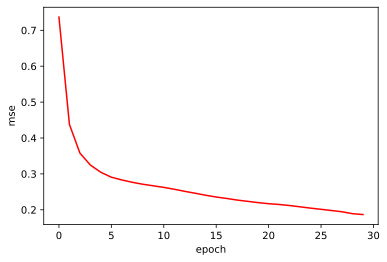

Epoch 1/30
636/636 [==============================] - 1s 1ms/step - loss: 0.1617 - mse: 0.1617
Epoch 2/30
636/636 [==============================] - 1s 1ms/step - loss: 0.0987 - mse: 0.0987
Epoch 3/30
636/636 [==============================] - 1s 1ms/step - loss: 0.0540 - mse: 0.0540
Epoch 4/30
636/636 [==============================] - 1s 1ms/step - loss: 0.0357 - mse: 0.0357
Epoch 5/30
636/636 [==============================] - 1s 1ms/step - loss: 0.0319 - mse: 0.0319
Epoch 6/30
636/636 [==============================] - 1s 1ms/step - loss: 0.0304 - mse: 0.0304
Epoch 7/30
636/636 [==============================] - 1s 1ms/step - loss: 0.0288 - mse: 0.0288
Epoch 8/30
636/636 [==============================] - 1s 959us/step - loss: 0.0282 - mse: 0.0282
Epoch 9/30
636/636 [==============================] - 1s 983us/step - loss: 0.0271 - mse: 0.0271
Epoch 10/30
636/636 [==============================] - 1s 998us/step - loss: 0.0263 - mse: 0.0263
Epoch 11/30
636/636 [======================

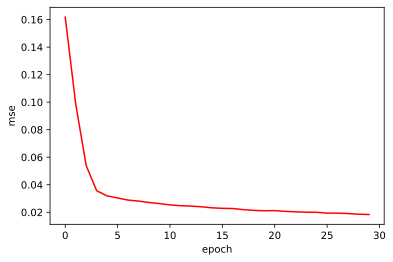

79/79 [==============================] - 0s 600us/step
Vizualization for FDC for training fold (shown in dark hue) 2and predicted clusters from neural network on testing fold (shown in corresponding light hues) 2


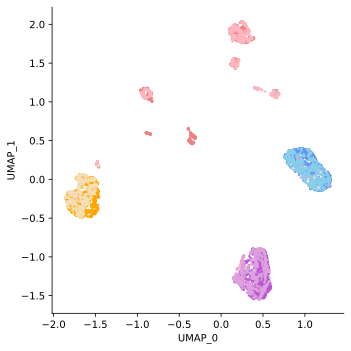

Average percentage of patients belongs to the same cluster is: 92.67057030538443%


Epoch 1/30
625/625 [==============================] - 1s 1ms/step - loss: 0.7316 - mse: 0.7316
Epoch 2/30
625/625 [==============================] - 1s 1ms/step - loss: 0.4436 - mse: 0.4436
Epoch 3/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3615 - mse: 0.3615
Epoch 4/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3260 - mse: 0.3260
Epoch 5/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3036 - mse: 0.3036
Epoch 6/30
625/625 [==============================] - 1s 1ms/step - loss: 0.2902 - mse: 0.2902
Epoch 7/30
625/625 [==============================] - 1s 1ms/step - loss: 0.2816 - mse: 0.2816
Epoch 8/30
625/625 [==============================] - 1s 1ms/step - loss: 0.2749 - mse: 0.2749
Epoch 9/30
625/625 [==============================] - 1s 1ms/step - loss: 0.2710 - mse: 0.2710
Epoch 10/30
625/625 [==============================] - 1s 1ms

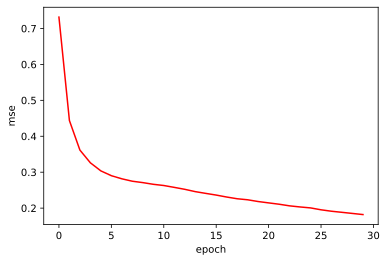

Epoch 1/30
625/625 [==============================] - 1s 1ms/step - loss: 0.1621 - mse: 0.1621
Epoch 2/30
625/625 [==============================] - 1s 1ms/step - loss: 0.0971 - mse: 0.0971
Epoch 3/30
625/625 [==============================] - 1s 1ms/step - loss: 0.0540 - mse: 0.0540
Epoch 4/30
625/625 [==============================] - 1s 1ms/step - loss: 0.0362 - mse: 0.0362
Epoch 5/30
625/625 [==============================] - 1s 1ms/step - loss: 0.0317 - mse: 0.0317
Epoch 6/30
625/625 [==============================] - 1s 1ms/step - loss: 0.0294 - mse: 0.0294
Epoch 7/30
625/625 [==============================] - 1s 1ms/step - loss: 0.0278 - mse: 0.0278
Epoch 8/30
625/625 [==============================] - 1s 1ms/step - loss: 0.0265 - mse: 0.0265
Epoch 9/30
625/625 [==============================] - 1s 1ms/step - loss: 0.0251 - mse: 0.0251
Epoch 10/30
625/625 [==============================] - 1s 1ms/step - loss: 0.0240 - mse: 0.0240
Epoch 11/30
625/625 [============================

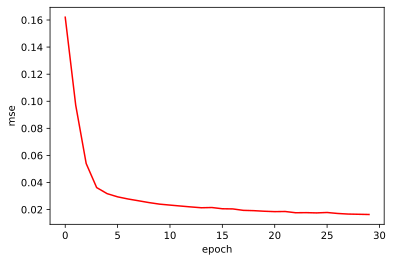

82/82 [==============================] - 0s 771us/step
Vizualization for FDC for training fold (shown in dark hue) 3and predicted clusters from neural network on testing fold (shown in corresponding light hues) 3


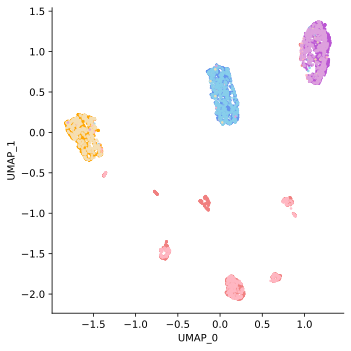

Average percentage of patients belongs to the same cluster is: 91.80899796243347%








In [24]:
np.random.seed(42)
count=0
fold_readings=[]
while count<3:
    FDC_emb_five_train=entire_data_FDC_emb_five.loc[list(training_folds[count].index)] #5D FDC embedding of training folds from entire training data
    FDC_emb_two_train=entire_data_FDC_emb_two.loc[list(training_folds[count].index)] #2D embedding of training folds from entire training data
    FDC_emb_five_train.columns=colnames
    
    #Thirty dimensional data of training fold as features_matrix(X_train) 
    features_matrix=np.array(training_folds[count].drop(cluster_column_names, axis=1,inplace=False)) #X_train
    
    #Five dimensional FDC embedding of training fold as target_matrix(y_train)
    target_matrix=np.array(FDC_emb_five_train) #y_train
    
    #Train a neural network to get five dimensional embedding
    model_1=neural_network(len(features_matrix[0]),int(0.6*len(features_matrix[0])),int(0.36*len(features_matrix[0])),len(target_matrix[0]),"relu","sigmoid","mse")
    history=model_1.fit(features_matrix,target_matrix,epochs=30,batch_size=8)
    print('\n')
    print('Training history across epochs for fold ',count+1)
    plt.plot(history.history['mse'],'r')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.show()
    
    #Using same thirty dimensional features_matrix(X_train) from first neural network and encoded cluster labels of training fold as target_labels_matrix(y_train) 
    target_labels_matrix=np.array(training_folds[count].loc[:,cluster_column_names]) #y
    
    
    #Train a neural network to get encoded cluster labels
    model_2=neural_network(len(features_matrix[0]),int(0.6*len(features_matrix[0])),int(0.36*len(features_matrix[0])),len(target_labels_matrix[0]),"relu","softmax","mse")
    history=model_2.fit(features_matrix,target_labels_matrix,epochs=30,batch_size=8)
    print('\n')
    print('Training history across epochs for fold ',count+1)
    plt.plot(history.history['mse'],'r')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.show()
    
    #Decoding cluster labels of training fold
    decoded_target_labels_matrix=label_decoder(target_labels_matrix)

    #Actual encoded cluster labels of testing fold for metric calculation  
    ref_clusters=testing_folds[count].loc[:,cluster_column_names] 
    #Decoding encoded cluster labels of testing fold
    decoded_ref_clusters=label_decoder(ref_clusters)
    

    #predicting testing fold to get five dim embedding using trained model_1
    testing_data=testing_folds[count].drop(cluster_column_names, axis=1,inplace=False)
    predicted_5dim=pd.DataFrame(model_1.predict(testing_data), columns=colnames)
    
    #UMAP on predicted 5D embedding
    predicted_2dim=feature_clustering(30,0.01, "euclidean", predicted_5dim, 0)

    #predicting testing fold to get encoded cluster labels using trained model_2
    predicted_clusters=pd.DataFrame(model_2.predict(testing_data))
    
    #Decoding predicted encoded cluster labels
    decoded_predicted_clusters=label_decoder(predicted_clusters)
    
    
    #concatinating training and predicted 5D embedding
    concatenated_5dim=pd.concat([FDC_emb_five_train,predicted_5dim])
    
    #UMAP on concatinated embedding
    two_dim_viz=feature_clustering(30, 0.01, 'euclidean', concatenated_5dim, 0)
    
    #Concatinating decoded cluster labels of training fold and predicted testing fold
    concatenated_cluster_labels=np.concatenate([np.array(decoded_target_labels_matrix),np.array(decoded_predicted_clusters)+len(np.unique(decoded_target_labels_matrix))])
    
    two_dim_viz['Cluster']= concatenated_cluster_labels
    
    
    #Setting dark colors for training folds    
    darkerhues=['lightcoral','cornflowerblue','orange','mediumorchid', 'lightseagreen','olive', 'chocolate','steelblue']
    colors_set2=[]
    for i in range(len(np.unique(decoded_target_labels_matrix))):
        colors_set2.append(darkerhues[i])
    
    #Concatinating dark colors for training folds and corresponding light colors for testing folds
    colors_set2=colors_set2+["lightpink", 'skyblue', 'wheat', "plum","paleturquoise",  "lightgreen",  'burlywood','lightsteelblue']
    
    print('Vizualization for FDC for training fold (shown in dark hue) '+str(count+1) + 'and predicted clusters from neural network on testing fold (shown in corresponding light hues) '+str(count+1))
    
    #visualizing the clusters of both training and testing folds
    sns.lmplot( x="UMAP_0", y="UMAP_1", data=two_dim_viz, fit_reg=False, legend=False, hue='Cluster', scatter_kws={"s": 3},palette=sns.set_palette(sns.color_palette(colors_set2))) 
    plt.show()
    
    #Metric calculation

    CIM_predicted=cluster_incidence_matrix_mod(np.array(decoded_predicted_clusters))#Cluster incidence metric for predicted clusters
    CIM_reference=cluster_incidence_matrix_mod(np.array(decoded_ref_clusters))#Cluster incidence metric for reference clusters
    Product=np.dot(CIM_predicted,CIM_reference)
    cluster_incdences_in_data=np.sum(CIM_reference,axis=1)  
    mean_points_in_same_clusters=np.mean(np.diagonal(Product)/cluster_incdences_in_data)
    fold_readings.append(mean_points_in_same_clusters*100)
    
    print("Average percentage of patients belongs to the same cluster is: {}%".format(mean_points_in_same_clusters*100))
    print('\n')
    count+=1


print('\n')
print('\n')


In [25]:
print('Average percentage of patients belonging to the same cluster over all three folds:', np.mean(np.array(fold_readings)))

Average percentage of patients belonging to the same cluster over all three folds: 92.08510450810154


## Validation

Epoch 1/30
950/950 [==============================] - 2s 1ms/step - loss: 0.6432 - mse: 0.6432
Epoch 2/30
950/950 [==============================] - 1s 1ms/step - loss: 0.3759 - mse: 0.3759
Epoch 3/30
950/950 [==============================] - 1s 1ms/step - loss: 0.3215 - mse: 0.3215
Epoch 4/30
950/950 [==============================] - 1s 1ms/step - loss: 0.2956 - mse: 0.2956
Epoch 5/30
950/950 [==============================] - 1s 1ms/step - loss: 0.2807 - mse: 0.2807
Epoch 6/30
950/950 [==============================] - 1s 1ms/step - loss: 0.2717 - mse: 0.2717
Epoch 7/30
950/950 [==============================] - 1s 1ms/step - loss: 0.2631 - mse: 0.2631
Epoch 8/30
950/950 [==============================] - 1s 1ms/step - loss: 0.2566 - mse: 0.2566
Epoch 9/30
950/950 [==============================] - 1s 1ms/step - loss: 0.2506 - mse: 0.2506
Epoch 10/30
950/950 [==============================] - 1s 1ms/step - loss: 0.2448 - mse: 0.2448
Epoch 11/30
950/950 [============================

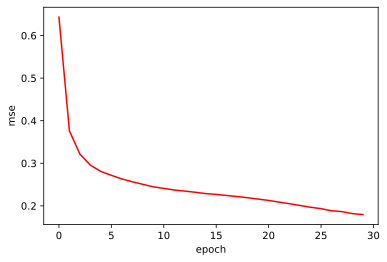

Epoch 1/30
950/950 [==============================] - 1s 973us/step - loss: 0.1454 - mse: 0.1454
Epoch 2/30
950/950 [==============================] - 1s 1ms/step - loss: 0.0784 - mse: 0.0784
Epoch 3/30
950/950 [==============================] - 1s 1ms/step - loss: 0.0394 - mse: 0.0394
Epoch 4/30
950/950 [==============================] - 1s 1ms/step - loss: 0.0316 - mse: 0.0316
Epoch 5/30
950/950 [==============================] - 1s 1ms/step - loss: 0.0284 - mse: 0.0284
Epoch 6/30
950/950 [==============================] - 1s 1ms/step - loss: 0.0268 - mse: 0.0268
Epoch 7/30
950/950 [==============================] - 1s 1ms/step - loss: 0.0254 - mse: 0.0254
Epoch 8/30
950/950 [==============================] - 1s 1ms/step - loss: 0.0241 - mse: 0.0241
Epoch 9/30
950/950 [==============================] - 1s 1ms/step - loss: 0.0234 - mse: 0.0234
Epoch 10/30
950/950 [==============================] - 1s 1ms/step - loss: 0.0226 - mse: 0.0226
Epoch 11/30
950/950 [==========================

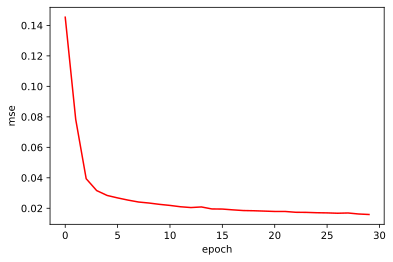

80/80 [==============================] - 0s 790us/step
Vizualization for FDC for training data (shown in dark hue) and predicted clusters from neural network on validation data (shown in corresponding light hues) 


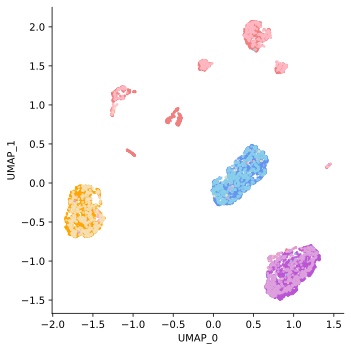

Average percentage of patients belongs to the same cluster is: 91.64254576794167%








In [26]:
np.random.seed(42)

FDC_emb_five_data=entire_data_FDC_emb_five.loc[list(data.index)] #5D FDC embedding of training fold from entire data
FDC_emb_two_data=entire_data_FDC_emb_two.loc[list(data.index)] #2D embedding of training fold from entire data
FDC_emb_five_data.columns=colnames

#Thirty dimensional data of training fold as features_matrix(X_train) 
features_matrix=np.array(data.drop(cluster_column_names, axis=1,inplace=False)) #X_train

#Five dimensional FDC embedding of training fold as target_matrix(y_train)
target_matrix=np.array(FDC_emb_five_data) #y_train

#Train a neural network to get five dimensional embedding
model_1=neural_network(len(features_matrix[0]),int(0.6*len(features_matrix[0])),int(0.36*len(features_matrix[0])),len(target_matrix[0]),"relu","sigmoid","mse")
history=model_1.fit(features_matrix,target_matrix,epochs=30,batch_size=8)
print('\n')
print('Training history across epochs for training data ')
plt.plot(history.history['mse'],'r')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.show()

#Using same thirty dimensional features_matrix(X_train) from first neural network and encoded cluster labels of training fold as target_labels_matrix(y_train) 
target_labels_matrix=np.array(data.loc[:,cluster_column_names]) #y


#Train a neural network to get encoded cluster labels
model_2=neural_network(len(features_matrix[0]),int(0.6*len(features_matrix[0])),int(0.36*len(features_matrix[0])),len(target_labels_matrix[0]),"relu","softmax","mse")
history=model_2.fit(features_matrix,target_labels_matrix,epochs=30,batch_size=8)
print('\n')
print('Training history across epochs for training data ')
plt.plot(history.history['mse'],'r')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.show()

#Decoding cluster labels of training fold
decoded_target_labels_matrix=label_decoder(target_labels_matrix)

#Actual encoded cluster labels of validation data for metric calculation  
ref_clusters=data_val.loc[:,cluster_column_names] 
#Decoding encoded cluster labels of validation data
decoded_ref_clusters=label_decoder(ref_clusters)


#predicting validation data to get five dim embedding using trained model_1
validation_data=data_val.drop(cluster_column_names, axis=1,inplace=False)
predicted_5dim=pd.DataFrame(model_1.predict(validation_data), columns=colnames)

#UMAP on predicted 5D embedding
predicted_2dim=feature_clustering(30,0.01, "euclidean", predicted_5dim, 0)

#predicting validation data to get encoded cluster labels using trained model_2
predicted_clusters=pd.DataFrame(model_2.predict(validation_data))

#Decoding predicted encoded cluster labels
decoded_predicted_clusters=label_decoder(predicted_clusters)


#concatinating training and predicted 5D embedding
concatenated_5dim=pd.concat([FDC_emb_five_data,predicted_5dim])

#UMAP on concatinated embedding
two_dim_viz=feature_clustering(30, 0.01, 'euclidean', concatenated_5dim, 0)

#Concatinating decoded cluster labels of training data and predicted validation data
concatenated_cluster_labels=np.concatenate([np.array(decoded_target_labels_matrix),np.array(decoded_predicted_clusters)+len(np.unique(decoded_target_labels_matrix))])

two_dim_viz['Cluster']= concatenated_cluster_labels



#Setting dark colors for training data    
darkerhues=['lightcoral','cornflowerblue','orange','mediumorchid', 'lightseagreen','olive', 'chocolate','steelblue']
colors_set2=[]
for i in range(len(np.unique(decoded_target_labels_matrix))):
    colors_set2.append(darkerhues[i])

#Concatinating dark colors for training data and corresponding light colors for validation data
colors_set2=colors_set2+["lightpink", 'skyblue', 'wheat', "plum","paleturquoise",  "lightgreen",  'burlywood','lightsteelblue']

print('Vizualization for FDC for training data (shown in dark hue) '+ 'and predicted clusters from neural network on validation data (shown in corresponding light hues) ')

#visualizing the clusters of both training and validation data
sns.lmplot( x="UMAP_0", y="UMAP_1", data=two_dim_viz, fit_reg=False, legend=False, hue='Cluster', scatter_kws={"s": 3},palette=sns.set_palette(sns.color_palette(colors_set2))) 
plt.show()

#Metric calculation

CIM_predicted=cluster_incidence_matrix_mod(np.array(decoded_predicted_clusters))#Cluster incidence metric for predicted clusters
CIM_reference=cluster_incidence_matrix_mod(np.array(decoded_ref_clusters))#Cluster incidence metric for reference clusters
Product=np.dot(CIM_predicted,CIM_reference)
cluster_incidences_in_data=np.sum(CIM_reference,axis=1)  
mean_points_in_same_clusters=np.mean(np.diagonal(Product)/cluster_incidences_in_data)
fold_readings.append(mean_points_in_same_clusters*100)

print("Average percentage of patients belongs to the same cluster is: {}%".format(mean_points_in_same_clusters*100))
print('\n')



print('\n')
print('\n')
